<a href="https://colab.research.google.com/github/SammyGbabs/Weather-Forecast-ML-Pipeline/blob/main/Weather_Forecast_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d zeeshier/weather-forecast-dataset

Dataset URL: https://www.kaggle.com/datasets/zeeshier/weather-forecast-dataset
License(s): CC0-1.0
  0% 0.00/114k [00:00<?, ?B/s]
100% 114k/114k [00:00<00:00, 62.0MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/weather-forecast-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [54]:
import numpy as np
from math import pi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.regularizers import l2

In [5]:
!pip install lightgbm


In [6]:
# Load your dataset
data = pd.read_csv('weather_forecast_data.csv')

In [7]:
# Print first 10 rows
print (data.head(10))
print(data.shape)

   Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain
5    26.147353  48.217260   15.258547    59.766279  1049.738751  no rain
6    20.939680  40.799444    2.232566    45.827508  1014.173766  no rain
7    32.294325  51.848471    2.873621    92.551497  1006.041733  no rain
8    34.091569  48.057114    5.570206    82.524873   993.732047  no rain
9    19.586038  82.978293    5.760537    98.014450  1036.503457     rain
(2500, 6)


In [8]:
#summarize the data
print(data.describe())

       Temperature     Humidity   Wind_Speed  Cloud_Cover     Pressure
count  2500.000000  2500.000000  2500.000000  2500.000000  2500.000000
mean     22.581725    64.347094     9.906255    49.658104  1014.312336
std       7.326996    19.954739     5.780316    29.123104    20.196433
min      10.001842    30.005071     0.009819     0.015038   980.014486
25%      16.359398    47.339815     4.761909    23.900016   996.938630
50%      22.536448    63.920797     9.908572    49.488284  1013.433035
75%      28.976476    81.561021    14.948408    75.324140  1031.735067
max      34.995214    99.997481    19.999132    99.997795  1049.985593


In [9]:
#check for missing values
print(data.isnull().sum())

Temperature    0
Humidity       0
Wind_Speed     0
Cloud_Cover    0
Pressure       0
Rain           0
dtype: int64


In [16]:
le = LabelEncoder()
data['Rain'] = le.fit_transform(data['Rain'])

In [20]:
data.head(5)

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,1
1,27.879734,46.489704,5.952484,4.990053,992.614190,0
2,25.069084,83.072843,1.371992,14.855784,1007.231620,0
3,23.622080,74.367758,7.050551,67.255282,982.632013,1
4,20.591370,96.858822,4.643921,47.676444,980.825142,0


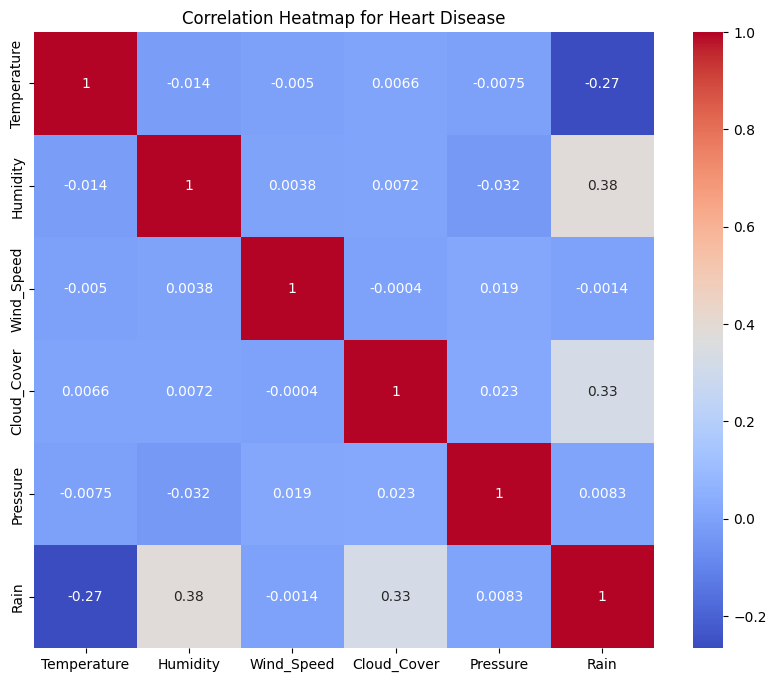

In [15]:
#Print correlation heat map
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Heart Disease')
plt.show()

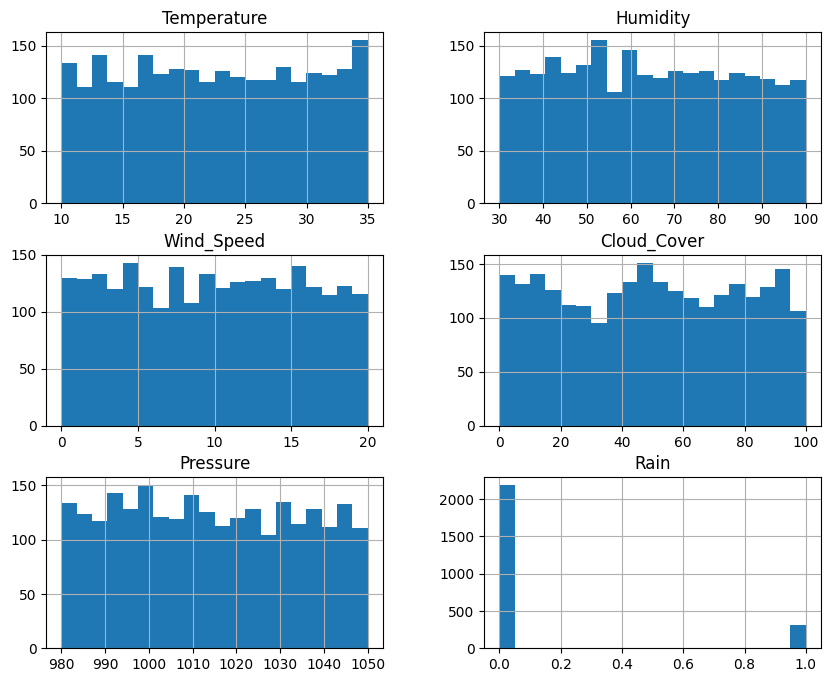

In [29]:
# Distribution of continuous variables.
data.hist(bins=20, figsize=(10, 8))
plt.show()


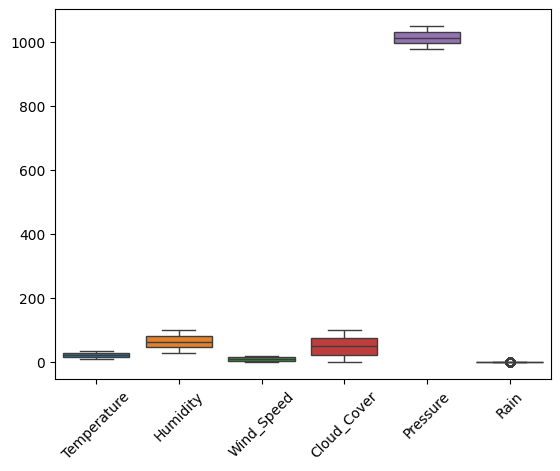

In [23]:
# Visualizations for Outliers
sns.boxplot(data)
plt.xticks(rotation=45)
plt.show()


<ipython-input-31-a4ddbe2687d7>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True, label=column)
<ipython-input-31-a4ddbe2687d7>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True, label=column)
<ipython-input-31-a4ddbe2687d7>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True, label=column)
<ipython-input-31-a4ddbe2687d7>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True, label=column)
<ipython-input-31-a4

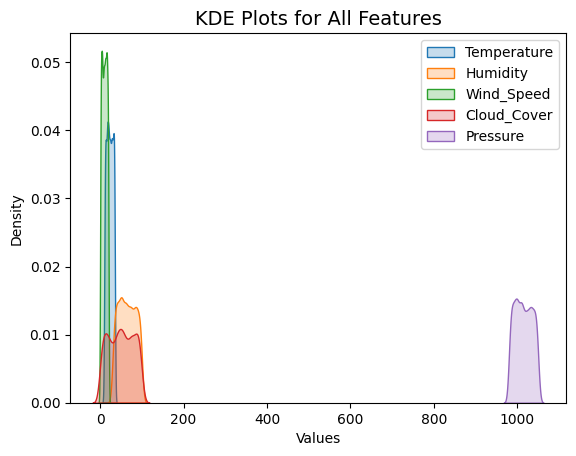

In [31]:
#Kernel Density Estimate for all features

# List of columns to plot (exclude the target column if necessary)
feature_columns = [col for col in data.columns if col != 'Rain']

for column in feature_columns:
    sns.kdeplot(data[column], shade=True, label=column)

plt.title("KDE Plots for All Features", fontsize=14)
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.show()


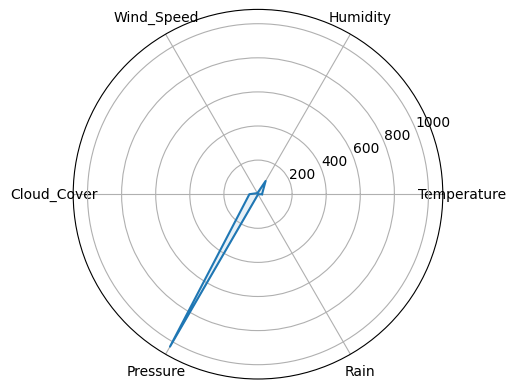

In [34]:
# Radar plot comparing multiple features across categories.
categories = list(data.columns)
values = data.iloc[0].values.flatten().tolist()
values += values[:1]  # Repeat the first value to close the radar chart

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories)
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.1)
plt.show()


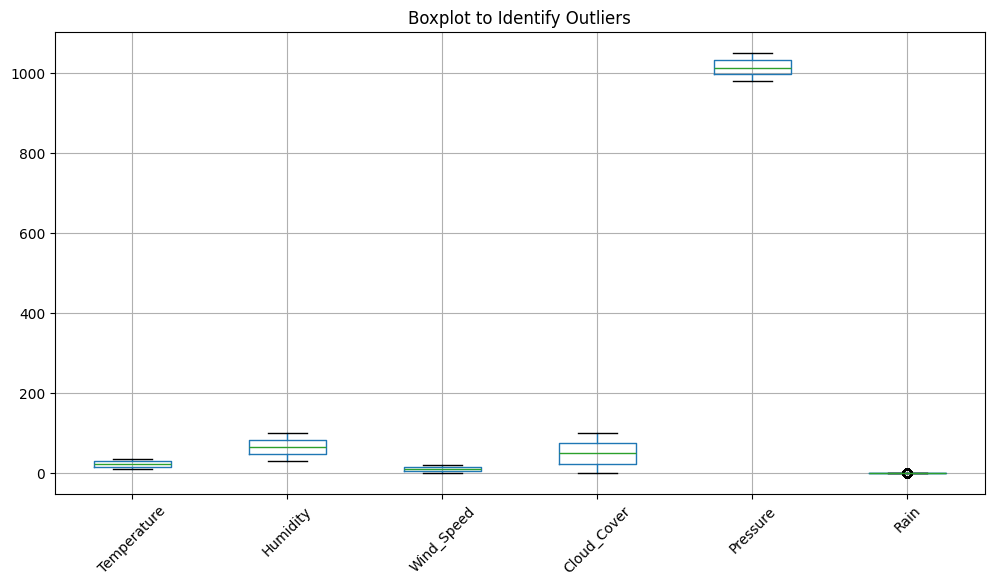

In [27]:
# Create a boxplot for each feature
data.boxplot(figsize=(12, 6), rot=45)
plt.title("Boxplot to Identify Outliers")
plt.show()


## **Data Preprocessing**

In [39]:
#Feature Selection
X=data.drop('Rain', axis=1)
y=data['Rain']

#Split data into train and test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize the data
scaler= MinMaxScaler()
X_train_Scaled= scaler.fit_transform(X_train)
X_test_Scaled= scaler.transform(X_test)

X_train_Scaled.shape


(2000, 5)

In [40]:
X_test_Scaled.shape


(500, 5)

## **Making Use of LightGBM to create my Model**

In [44]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train_Scaled, label=y_train)
test_data = lgb.Dataset(X_test_Scaled, label=y_test, reference=train_data)

# Define LightGBM parameters
params = {
    'objective': 'binary',             # For binary classification
    'boosting_type': 'gbdt',           # Gradient Boosting Decision Trees
    'metric': 'binary_error',          # Error rate metric
    'learning_rate': 0.1,              # Learning rate
    'num_leaves': 31,                  # Number of leaves in one tree
    'max_depth': -1,                   # Unlimited tree depth
    'verbose': -1                      # Suppress output
}

# Define early stopping callback
early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=True)

# Train the model
lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],  # Assign names to the validation sets
    num_boost_round=1000,              # Maximum boosting iterations
    callbacks=[early_stopping_callback],          # Early stopping to prevent overfitting
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's binary_error: 0.001	test's binary_error: 0


In [45]:
# Make predictions
y_pred = lgbm_model.predict(X_test_Scaled)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

In [48]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       443
           1       1.00      1.00      1.00        57

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


Confusion Matrix:
[[443   0]
 [  0  57]]


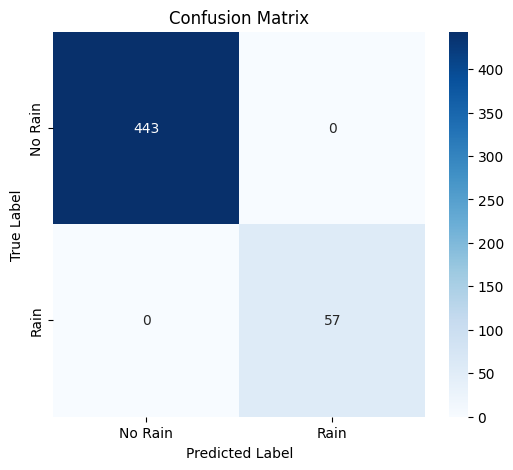

In [49]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [53]:
import joblib
import pickle

# Save the model using pickle
model_file = "lgbm_model.pkl"  # You can use .pkl extension for pickle
with open(model_file, 'wb') as f:
    pickle.dump(lgbm_model, f)

print(f"Model saved to {model_file}")


# Save the model
model_file = "lightgbm_model.pkl"
joblib.dump(lgbm_model, model_file)

print(f"Model saved to {model_file}")

Model saved to lgbm_model.pkl
Model saved to lightgbm_model.pkl


## **Making Use of Optimized Model**

In [56]:
# Initialize the sequential model
model = Sequential()

# Input layer and first hidden layer with Dropout
model.add(Dense(128, input_dim=X_train_Scaled.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))

# Second hidden layer with Dropout
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))

# Third hidden layer with Dropout
model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))


# Output layer (binary classification with sigmoid activation)
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 128)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback (optional, to avoid overfitting)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model on the training data (with validation split)
history = model.fit(X_train_Scaled, y_train, epochs=100, validation_split=0.2,
                              callbacks=[early_stop], batch_size=32)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8632 - loss: 0.6534 - val_accuracy: 0.8700 - val_loss: 0.4095
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8826 - loss: 0.3660 - val_accuracy: 0.8700 - val_loss: 0.3567
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8593 - loss: 0.3691 - val_accuracy: 0.8700 - val_loss: 0.2944
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8840 - loss: 0.2687 - val_accuracy: 0.8700 - val_loss: 0.2299
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8666 - loss: 0.2444 - val_accuracy: 0.8700 - val_loss: 0.2013
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8715 - loss: 0.2249 - val_accuracy: 0.8700 - val_loss: 0.1858
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8675 - loss: 0.1857 - val_accuracy: 0.8700 - val_loss: 0.1741
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.1782 - val_accuracy: 0.8700 - v

In [63]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_Scaled, y_test)
print(f"Test Loss: {test_loss}\n Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred_prob = model.predict(X_test_Scaled)

# Convert probabilities to binary predictions (threshold > 0.5)
y_pred_model = (y_pred_prob > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0407 
Test Loss: 0.03999290615320206
 Test Accuracy: 0.9919999837875366
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Confusion Matrix:
[[442   1]
 [  3  54]]


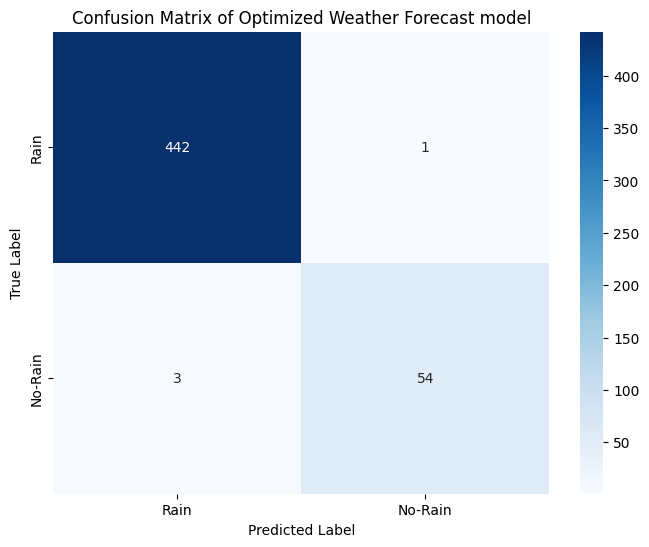

Classification Report:
              precision    recall  f1-score   support

        Rain       0.99      1.00      1.00       443
     No-Rain       0.98      0.95      0.96        57

    accuracy                           0.99       500
   macro avg       0.99      0.97      0.98       500
weighted avg       0.99      0.99      0.99       500



In [64]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_model)
print("Confusion Matrix:")
print(conf_matrix)

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rain', 'No-Rain'], yticklabels=['Rain', 'No-Rain'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Optimized Weather Forecast model')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_model, target_names=['Rain', 'No-Rain']))

In [65]:
# Save the optimized model
model.save('/content/drive/MyDrive/Weather forecast Summative/Weather_forecast_model.h5')